[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 concepts.

* Using [chat messages](https://docs.langchain.com/oss/python/langchain/messages) as our graph state
* Using [chat models](https://docs.langchain.com/oss/python/integrations/chat) in graph nodes
* [Binding tools](https://docs.langchain.com/oss/python/langchain/models#tool-calling) to our chat model
* [Executing tool calls](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models can use [messages](https://docs.langchain.com/oss/python/langchain/messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

Chat models use a sequence of messages as input and support message types, as discussed above.

There are [many](https://docs.langchain.com/oss/python/integrations/chat) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [29]:
result

AIMessage(content='Great question. In the United States, the most reliable and popular places to see wild orcas are:\n\n1) San Juan Islands / Puget Sound, Washington\n- Why it’s great: Easy to reach from Seattle or Vancouver, with strong chances to see Southern Residents (and some Transients) during the salmon season.\n- Best time: May–October, with peak sightings around July–September when salmon runs attract the pods.\n- How to do it: Book a licensed whale-watching tour from Friday Harbor, Anacortes, or nearby towns. Operators follow NOAA guidelines to keep a safe distance.\n- What you’ll see: Orcas, along with other marine life like seals and porpoises; often several pods in a day.\n- Tips: Choose a large-boat or small-boat operator with a good track record; bring layers, expect choppy weather, and be prepared for variable seas.\n\n2) Southeast Alaska (Juneau, Sitka, and other Inside Passage communities)\n- Why it’s great: Some of the most abundant and photogenic orca viewing in a s

In [30]:
result.response_metadata

{'token_usage': {'completion_tokens': 3275,
  'prompt_tokens': 70,
  'total_tokens': 3345,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 2688,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_provider': 'openai',
 'model_name': 'gpt-5-nano-2025-08-07',
 'system_fingerprint': None,
 'id': 'chatcmpl-CzpPTiP11TUFfPqnjgcMfEc2VtKr1',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [21]:
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
agent = init_chat_model("gpt-5-nano")
response = agent.invoke("Hello World!")

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://docs.langchain.com/oss/python/integrations/chat) and [tool calling interface](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [32]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [42]:
from pprint import pp
pp(tool_call.to_json())

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'AIMessage'],
 'kwargs': {'content': '6',
            'additional_kwargs': {'refusal': None},
            'response_metadata': {'token_usage': {'completion_tokens': 138,
                                                  'prompt_tokens': 143,
                                                  'total_tokens': 281,
                                                  'completion_tokens_details': {'accepted_prediction_tokens': 0,
                                                                                'audio_tokens': 0,
                                                                                'reasoning_tokens': 128,
                                                                                'rejected_prediction_tokens': 0},
                                                  'prompt_tokens_details': {'audio_tokens': 0,
                                                                            'cached_

## ChatOpenAI - bind_tools - `gpt-5-nano`
* GPT 5 nano requires explicity directive to use the tool; otherwise it calculates it itself.

In [55]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])
tool_call = llm_with_tools.invoke([HumanMessage(content=f"Use the multipy tool to calculate 2 multiplied by 3", name="Lance")])

In [56]:
pp(tool_call.to_json())

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'AIMessage'],
 'kwargs': {'content': '',
            'additional_kwargs': {'refusal': None},
            'response_metadata': {'token_usage': {'completion_tokens': 282,
                                                  'prompt_tokens': 154,
                                                  'total_tokens': 436,
                                                  'completion_tokens_details': {'accepted_prediction_tokens': 0,
                                                                                'audio_tokens': 0,
                                                                                'reasoning_tokens': 256,
                                                                                'rejected_prediction_tokens': 0},
                                                  'prompt_tokens_details': {'audio_tokens': 0,
                                                                            'cached_t

## ChatOpenAI - bind_tools - `gpt-4o`

In [45]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [46]:
pp(tool_call.to_json())

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'AIMessage'],
 'kwargs': {'content': '',
            'additional_kwargs': {'refusal': None},
            'response_metadata': {'token_usage': {'completion_tokens': 17,
                                                  'prompt_tokens': 68,
                                                  'total_tokens': 85,
                                                  'completion_tokens_details': {'accepted_prediction_tokens': 0,
                                                                                'audio_tokens': 0,
                                                                                'reasoning_tokens': 0,
                                                                                'rejected_prediction_tokens': 0},
                                                  'prompt_tokens_details': {'audio_tokens': 0,
                                                                            'cached_tokens

In [24]:
agent = init_chat_model(
    model="gpt-5-nano",
    )
agent.bind_tools([multiply])
print(agent)

profile={'max_input_tokens': 272000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True} client=<openai.resources.chat.completions.completions.Completions object at 0x115c1aed0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1160b14d0> root_client=<openai.OpenAI object at 0x1145f77d0> root_async_client=<openai.AsyncOpenAI object at 0x115f14110> model_name='gpt-5-nano' model_kwargs={} openai_api_key=SecretStr('**********') stream_usage=True


In [26]:
response = agent.invoke("What is 2 multiplied by 3")
response

AIMessage(content='6', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 14, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CzpMzQ5OfCFsDZuJ08L3FxiwljfR8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bd7c4-0db7-74e1-ae4b-ace6a29e6576-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 14, 'output_tokens': 138, 'total_tokens': 152, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}})

## Using messages as state

With these foundations in place, we can now use  [messages](https://docs.langchain.com/oss/python/langchain/overview#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [48]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will overwrite the prior `messages` value!
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers) to address this.

Reducers specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [49]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built  [`MessagesState`](https://docs.langchain.com/oss/python/langgraph/graph-api#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [50]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [51]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='b3576304-72e2-4f2f-9acf-a66b0a49abe9', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='0313237e-2090-4b2a-9ec6-8dfb65cdad3e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='75257836-6c30-4bd2-89f0-64f9e51ac410', tool_calls=[], invalid_tool_calls=[])]

## Our graph

Now, lets use `MessagesState` with a graph.

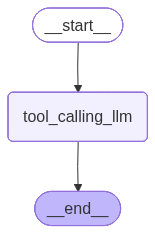

In [57]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [53]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! Nice to meet you. How can I help today? I can answer questions, explain concepts, help with writing or editing, assist with coding or math, plan a project, or brainstorm ideas. Tell me what you’d like to do or what topic you’re interested in.


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [54]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Hhv0avpFKzQRMf39eUEZHfWz)
 Call ID: call_Hhv0avpFKzQRMf39eUEZHfWz
  Args:
    a: 2
    b: 3
